# How to install dask in colab
> a basic introduction to dask and how to install dask in colab

- toc: true
- badges: true
- comments: true
- categories: [dask, colab, bigdata]
- image: 

### Learn more

- ["Dask Video Tutorial"](https://github.com/jacobtomlinson/dask-video-tutorial-2020) 
- [YouTube link](https://www.youtube.com/watch?v=_u0OQm9qf_A)
- [Introduction To Dask by Richard (Rick) Zamora](https://github.com/rjzamora/notebooks/tree/master/nvtabular_dask_demo)

Other useful Dask resources:
- [Dask.org](https://dask.org/)
    - [Tutorial pages](https://tutorial.dask.org/00_overview.html)
- [GitHub Tutorial](https://github.com/dask/dask-tutorial)

## What is Dask

**Very Short Answer**: Dask is an open-source library designed to natively scale Python code.

**Slightly-Longer Short Answer**: Dask is a task-based library for parallel scheduling and execution. Although it is certainly possible to use the task-scheduling machinery directly to implement customized parallel workflows (we do it in NVTabular), most users only interact with Dask through a *Dask Collection API*.  The most popular "collection" API's include:

- [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html): Dask-based version of the [Pandas](https://pandas.pydata.org/) DataFrame/Series API.  Note that `dask_cudf` is just a wrapper around this collection module (`dask.dataframe`).
- [Dask Array](https://docs.dask.org/en/latest/array.html): Dask-based version of the [NumPy]() array API
- [Dask Bag](https://docs.dask.org/en/latest/bag.html): *Similar to* a Dask-based version of PyToolz or a Pythonic version of PySpark RDD


For example, Dask DataFrame provides a convenient API for decomposing large pandas (or cuDF) DataFrame/Series objects into a collection of DataFrame *partitions*.  This tutorial will focus mostly on this particular Dask collection (since it is the basis for `dask_cudf`).  However, instead of relying only on the established `dask.dataframe` API, we will also see how it is possible (perhaps easy) to implement a custom task graph to operate on Dask-DataFrame objects when necessary.

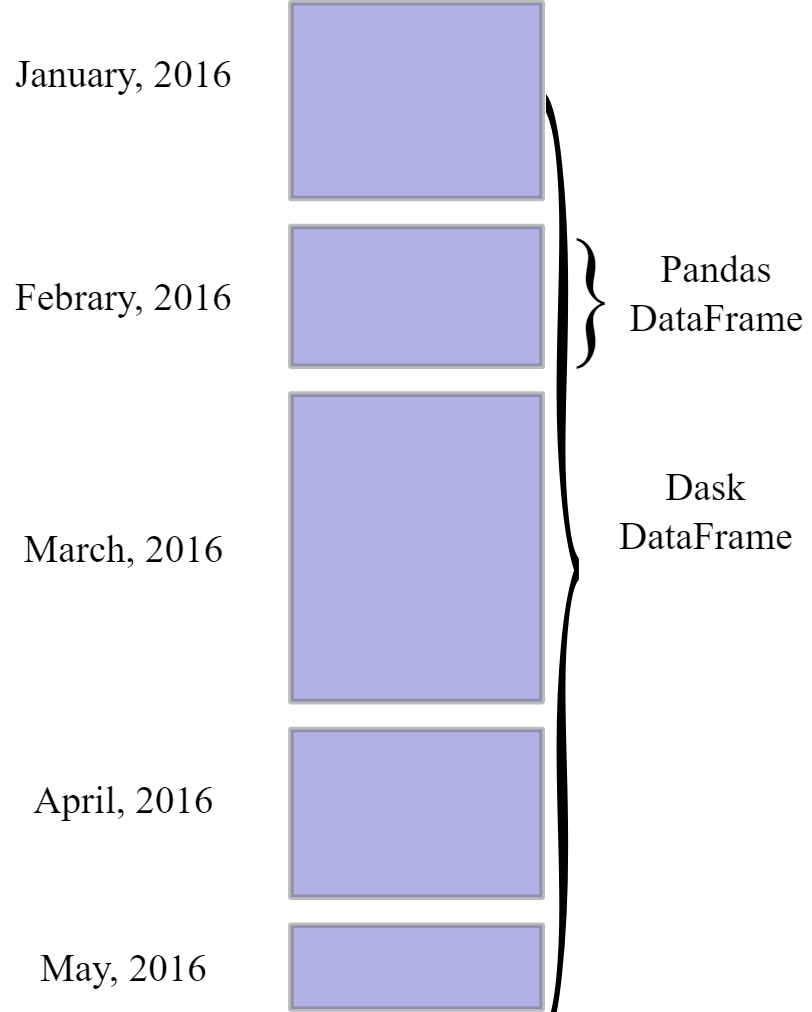

### Dask Uses DAGs Internally

Before we start writing any code, it is useful to understand (on a basic level) how Dask actually works. When an application or library uses a Dask collection API (like Dask DataFrame), they are typically using that API to construct a directed acyclic graph (DAG) of tasks.  Once a DAG is constructed, the **core** Dask API can be used (either directly or implicitly through the collection API) to schedule and execute the DAG on one or more threads/processes.

In other words, Dask provides various APIs to:

1. Construct a DAG of "tasks"
2. Schedule/execute those DAGs
3. (Optionally) Spin up a dedicated worker and scheduler processes to enable distributed execution

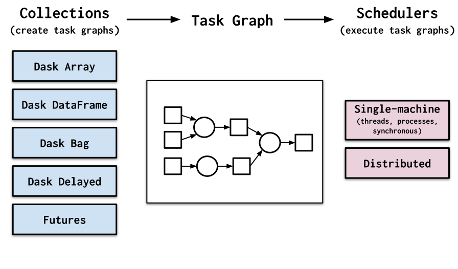

### Important Components of the "Dask Ecosystem"

The components of the Dask ecosystem that are most critical for NVTabular (and will be discussed in this tutorial) are:

- `dask` (core Dask library): [[GitHub Repo](https://github.com/dask/dask)]  This is the core Dask library.  It also contains the Dask Dataframe API (`dask.dataframe`)
- `dask_cudf`: [[GitHub Repo](https://github.com/rapidsai/cudf/tree/branch-0.15/python/dask_cudf)] This is effectively a wrapper around the `dask.dataframe` module defined in the core Dask library.  Note that a `dask_cudf.DataFrame` object should be thought of as a `dask.dataframe.DataFrame` object, but with the underlying partitions being `cudf.DataFrame`'s (rather than `pandas.DataFrame`)
- `distributed`: [[GitHub Repo](https://github.com/dask/distributed)] Distributed version of the Dask execution model (includes the necessary code for scheduling, execution and communication between distributed processes).  This library does not deal with the construction of DAGs, just with the scheduling and execution of DAGs on distributed *workers*.
- `dask_cuda`: [[GitHub Repo](https://github.com/rapidsai/dask-cuda)] Provides various utilities to improve deployment and management of distributed Dask *workers* on CUDA-enabled systems.

### Dask cluster starting

In [1]:
!pip install dask[dataframe]
!pip install "tornado>=5" 
!pip install "dask[complete]"
!pip install dask distributed --upgrade

     |████████████████████████████████| 122kB 8.4MB/s 
     |████████████████████████████████| 727kB 8.4MB/s 
ERROR: distributed 2021.6.1 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.6.1 has requirement dask==2021.06.1, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3
     |████████████████████████████████| 983kB 8.2MB/s 
Requirement already up-to-date: distributed in /usr/local/lib/python3.7/dist-packages (2021.6.1)
ERROR: distributed 2021.6.1 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
  Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0


In [2]:
import dask
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd

In [3]:
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='6GB')
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://172.28.0.2:8787/status,
Status: running,Using processes: False
Dashboard: http://172.28.0.2:8787/status,Workers: 1
Total threads: 4,Total memory: 5.59 GiB
Comm: inproc://172.28.0.2/63/1,Workers: 1
Dashboard: http://172.28.0.2:8787/status,Total threads: 4
Started: Just now,Total memory: 5.59 GiB
Comm: inproc://172.28.0.2/63/3,Total threads: 4
Dashboard: http://172.28.0.2:38697/status,Memory: 5.59 GiB
Nanny: None,
